Author: K. Geil

Date: 03/2023

Description: prepare all input data for running pyAEZ module 1 at global scale for 1 year

Notes:

## Set up

In [1]:
import numpy as np
import glob

import rioxarray as rio
import xarray as xr

from natsort import natsorted 
import dask.array as da

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd


In [2]:
# your notebook directory location
work_dir='K:/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/'

# your data directory location
# data_dir='C:/Users/kerrie/Documents/02_LocalData/DataDownload03152023/'
data_dir='C:/Users/kerrie.WIN/Documents/data/DataDownload03152023/'

# your output data file directory
out_dir='C:/Users/kerrie.WIN/Documents/data/pyAEZ_data_inputs_03152023/'

# linux path of project directory (to include in file metadata)
# this one is the same for everyone
source_dir='/gri/projects/rgmg/climate/UN_FAO/'

# input file name components
dataset='AgERA5'
experiment='Hist'
year='1980'
months=[str(x).rjust(2,'0') for x in np.arange(1,13)]
gridsize='5m'
file_ext_d='.pxv'
file_exts_m=['.rst','.rdc']
variables=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m','Elevation','Mask']

# some constants
landfrac_thresh=2500
month_int=np.arange(1,13)


# metadata for output data files
timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lat_encoding={'_FillValue':None}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}
lon_encoding={'_FillValue':None}


In [3]:
# create middle of the month datetimes
# these will be assigned to the time dim of climate data
time_ms=pd.date_range(year+'-01-01',year+'-12-31',freq='MS')
time_me=pd.date_range(year+'-01-01',year+'-12-31',freq='M')+pd.Timedelta('1d')
offset=(time_me-time_ms)/2
time=time_me-offset
# time

## Define functions

In [4]:
# function for getting a list of data files
def getFilelist(var,ext):
    if (var=='Elevation'):
        filelist=[data_dir+'ALOSdem5m_fill.rst']
    elif (var=='Mask'):
        filelist=[data_dir+'ALOSmask5m_fill.rst']     
    else:
        filename=var+'_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+ext
        filelist=natsorted(glob.glob(data_dir+'Climate/monthly/'+filename))

    return filelist

In [5]:
# function to load data into xarray dataset
def loadData(filelist):
    if (len(filelist)>1):
        time_ms=pd.date_range(year+'-01-01',year+'-12-31',freq='MS')
        time_me=pd.date_range(year+'-01-01',year+'-12-31',freq='M')+pd.Timedelta('1d')
        offset=(time_me-time_ms)/2
        time=time_me-offset

        data=[]
        for t,f in zip(time,filelist):
            d=xr.open_dataset(f,engine='rasterio')
            d=d.rename({'band':'time'})
            d.coords['time']=[t]
            data.append(d)
        ds=xr.combine_by_coords(data)
    else:
        ds=xr.open_dataset(filelist[0],engine='rasterio').squeeze() 

    return ds

## Create binary admin mask


In [6]:
# load the data
filelist=getFilelist('Mask','.rst')
ds=loadData(filelist)
ds


<xarray.Dataset>
Dimensions:      (x: 4320, y: 2160)
Coordinates:
    band         int32 1
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 ...
Data variables:
    band_data    (y, x) float32 ...

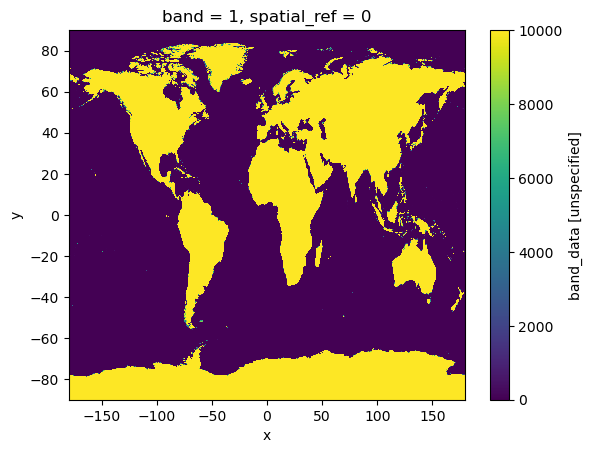

In [7]:
# look at it
ds.band_data.plot()

[0 1]


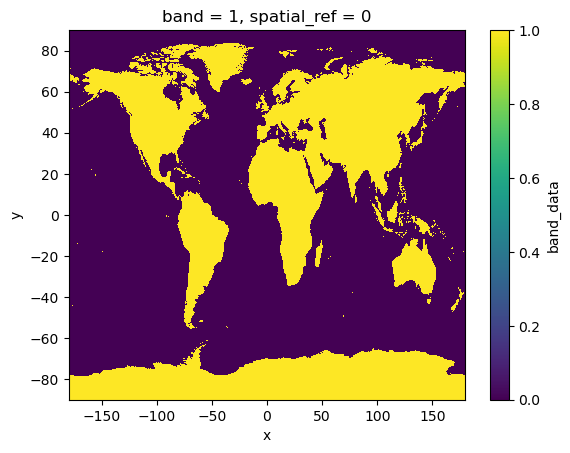

In [8]:
# create binary mask, verify all 0,1, look at it
ds['band_data']=xr.where(ds.band_data>landfrac_thresh,1,0)
print(np.unique(ds.band_data.data))
ds.band_data.plot()

In [9]:
# make pretty and attach metadata

# get rid of singleton dim info
del ds.coords['band']

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':'admin_mask'})

# variable/coordinate metadata
varattrs={'standard_name':'admin_mask','long_name':'Mask','units':'unitless','description':'binary administrative mask'}
ds['admin_mask'].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/ALOSmask5m_fill.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/data_prep.ipynb'})

ds


<xarray.Dataset>
Dimensions:      (lon: 4320, lat: 2160)
Coordinates:
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 ...
Data variables:
    admin_mask   (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/ALOS...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/data_prep...

In [10]:
# write to file
ds.to_netcdf(out_dir+'admin_mask.nc',
            mode='w',
            format='NETCDF4',
            encoding={'lat':lat_encoding,'lon':lon_encoding})

## Compute 2m wind

In [11]:
# load the data
filelist=getFilelist('Wind-10m','.rst')
ds=loadData(filelist)
ds

<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float32 nan nan nan nan ... 3.911 3.911 3.911

In [12]:
# interpolate 10m wind to 2m wind
height=10
z_adjust=4.87/(np.log(67.8*height-5.42))
print(z_adjust)
ds_2m=ds*z_adjust
ds_2m

0.7479510751679441


<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float32 nan nan nan nan ... 2.925 2.926 2.926

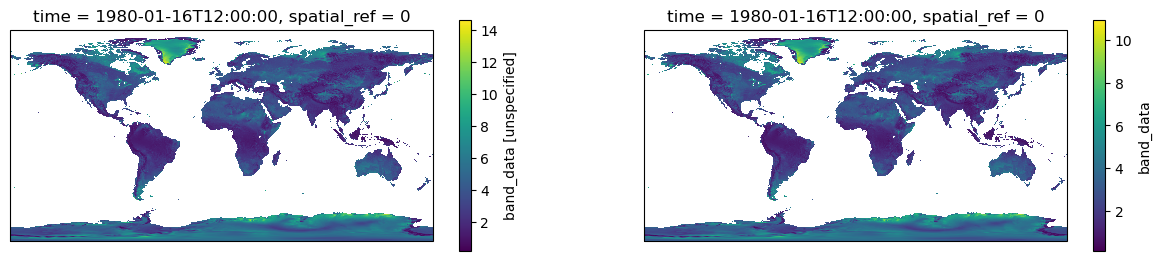

In [13]:
# visualize
fig=plt.figure(figsize=(15,3))
ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ds.band_data[0,:,:].plot(ax=ax)
ax=fig.add_subplot(122,projection=ccrs.PlateCarree())
ds_2m.band_data[0,:,:].plot(ax=ax)
plt.show()

In [14]:
# make pretty and attach metadata
ds=ds_2m.copy()

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':'wind_speed'})

# variable/coordinate metadata
varattrs={'standard_name':'wind_speed','long_name':'2m Wind Speed','units':'m s-1','description':'wind speed at 2m above surface'}
ds['wind_speed'].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Wind-10m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lon: 4320, lat: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    wind_speed   (time, lat, lon) float32 nan nan nan nan ... 2.925 2.926 2.926
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Wind...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/data_prep...

In [15]:
# write to file
ds.to_netcdf(out_dir+'wind_speed_monthly_'+year+'.nc',mode='w',format='NETCDF4',unlimited_dims='time',
            encoding={'time':time_encoding,'lat':lat_encoding,'lon':lon_encoding})

## Convert radiation units

In [16]:
# set constants
# var='SRad'
# file_ext='.rst'
# filename=var+'_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+file_ext
# filelist=natsorted(glob.glob(data_dir+'Climate/monthly/'+filename))
# month_int=np.arange(1,13)

# load the data
filelist=getFilelist('SRad','.rst')
ds=loadData(filelist)
print(ds.band_data.min().data,ds.band_data.max().data)
ds

-9928.06 40414590.0


<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float32 nan nan nan ... 3.806e+07 3.806e+07

The rds metadata file doesn't have a lot of info on what this is. I'm assuming it's average monthly *incoming* solar radiation *at the surface*. In which case there should be no negative values.

Let's look at where this data is negative

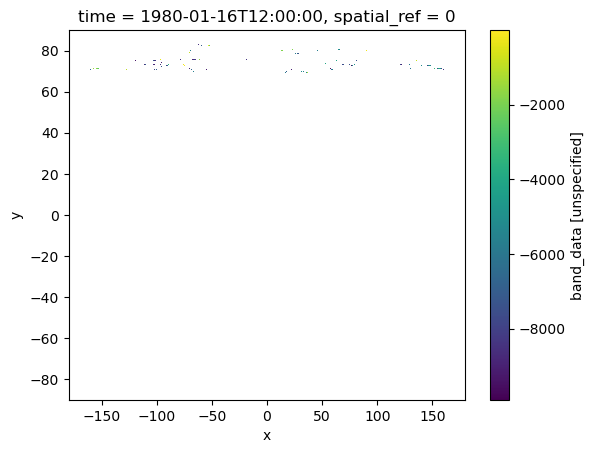

In [17]:
dplot=ds.band_data[0,:,:]
dplot=dplot.where(dplot<0)
dplot.plot()

ok so weird stuff going on at high latitudes. We'll set negatives equal to 0

In [18]:
ds=xr.where(ds<0,0,ds)
print(ds.band_data.min().data,ds.band_data.max().data)

0.0 40414590.0


In [19]:
# Convert J/m2/day to W/m2
s_per_day=86400
ds_Wm2=ds/s_per_day
print(ds_Wm2.band_data.min().data,ds_Wm2.band_data.max().data)
ds_Wm2

0.0 467.7614814814815


<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float64 nan nan nan nan ... 440.5 440.5 440.5

In [20]:
# make pretty and attach metadata
ds=ds_Wm2.copy()

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':'short_rad'})

# variable/coordinate metadata
varattrs={'standard_name':'short_rad',
        'long_name':'surf short wave rad down',
        'units':'W m-2',
        'description':'downwelling shortwave radiation at the surface'}
ds['short_rad'].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Srad_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lon: 4320, lat: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    short_rad    (time, lat, lon) float64 nan nan nan nan ... 440.5 440.5 440.5
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Srad...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/data_prep...

In [21]:
# write to file
ds.to_netcdf(out_dir+'short_rad_monthly_'+year+'.nc',mode='w',format='NETCDF4',unlimited_dims='time',
            encoding={'time':time_encoding,'lat':lat_encoding,'lon':lon_encoding})

## Create relative humidity

In [22]:
# load data
file_ext='.rst'
var='Tmin-2m'
filelist=getFilelist(var,file_ext)
Tmin=loadData(filelist).band_data

var='Tmax-2m'
filelist=getFilelist(var,file_ext)
Tmax=loadData(filelist).band_data

var='Vapr'
filelist=getFilelist(var,file_ext)
Vapr=loadData(filelist).band_data

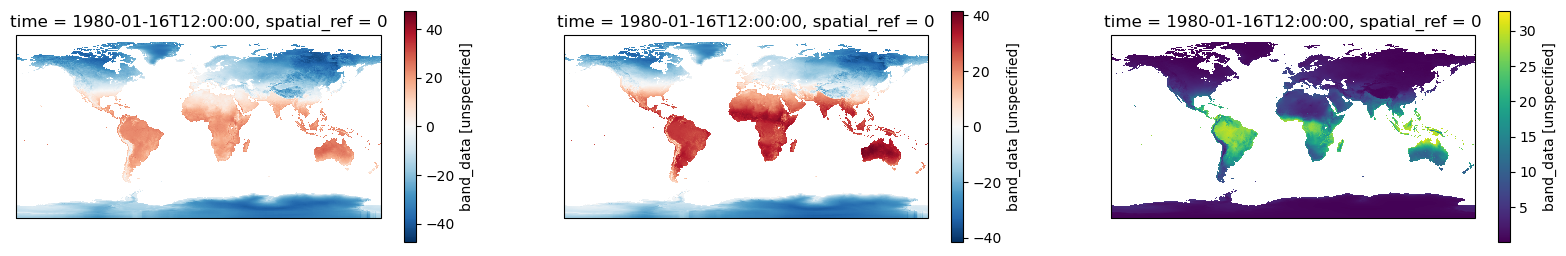

In [24]:
# visualize
fig=plt.figure(figsize=(20,3))
ax=fig.add_subplot(131,projection=ccrs.PlateCarree())
Tmin[0,:,:].plot(ax=ax)
ax=fig.add_subplot(132,projection=ccrs.PlateCarree())
Tmax[0,:,:].plot(ax=ax)
ax=fig.add_subplot(133,projection=ccrs.PlateCarree())
Vapr[0,:,:].plot(ax=ax)
plt.show()

In [ ]:
# convert units 
# vapor pressure hPa to kPa
Vapr=0.1*Vapr



Actually we need to compute RH on daily data and then average to monthly. Come back to this when you get the daily data